In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from bitalg.tests.test3 import Test
from bitalg.visualizer.main import Visualizer

In [27]:
def draw_polygon(polygon):
    vis = Visualizer()
    vis.add_polygon(polygon, fill=False)
    vis.show()

In [28]:
def draw_polygon_with_edges(polygon, edges):
    vis = Visualizer()
    vis.add_polygon(polygon, fill=False)
    for e in edges:
        vis.add_line_segment((polygon[e[0]], polygon[e[1]]))
    vis.show()

In [29]:
def draw_polygon_colors(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in range(len(polygon)):
        if colors[i]==0:
            points_start.append(polygon[i])
        elif colors[i]==1:
            points_end.append(polygon[i])
        elif colors[i]==2:
            points_connect.append(polygon[i])
        elif colors[i]==3:
            points_divide.append(polygon[i])
        elif colors[i]==4:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [30]:
def draw_polygon_tri(polygon, diags, edges):
    vis = Visualizer()
    tri_line_segments = list(map(lambda x: (polygon[x[0]], polygon[x[1]]), diags))
    vis.add_polygon(polygon, fill=False)
    vis.add_line_segment(tri_line_segments, color='red')
    for e in edges:
        vis.add_line_segment((polygon[e[0]], polygon[e[1]]), color="blue", zorder=100)
    vis.show()

# Wczytywanie wielokątów

In [31]:
def save_polygon_to_file(polygon, file_path):
    with open(file_path, 'w') as file:
        for item in polygon:
            file.write(f"{item[0]} {item[1]}\n")

def read_polygon_from_file(file_path):
    polygon = []
    with open(file_path, 'r') as file:
        for line in file:
            polygon.append(tuple(map(lambda x: float(x), line.split())))
    
    return polygon

def save_triangulation_to_file(polygon, triangles, file_path):
    with open(file_path, 'w') as file:
        file.write(f"{len(polygon)}\n")
        for item in polygon:
            file.write(f"{item[0]} {item[1]}\n")
        for item in triangles:
            file.write(f"{item[0]} {item[1]} {item[2]}\n")

Funkcja wczytująca wielokąt od użytkownika 

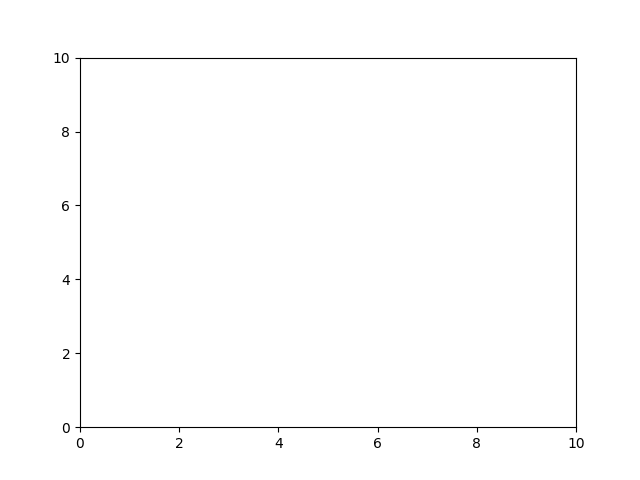

In [32]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])

mouse_input_polygon = []
points_x = []
points_y = []
eps = 0.1
finished = False

def onclick(event):
    global finished, mouse_input_polygon
    if len(points_x) > 0 and abs(points_x[0] - event.xdata) < eps and abs(points_y[0] - event.ydata) < eps: 
        mouse_input_polygon = list(zip(points_x, points_y))
        points_x.append(points_x[0])
        points_y.append(points_y[0])
        finished = True
    if not finished:
        points_x.append(event.xdata)
        points_y.append(event.ydata)
        col = 'blue'
    else:
        col = 'green'
    plt.plot(points_x, points_y, '.', c=col)
    plt.plot(points_x, points_y, c=col)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

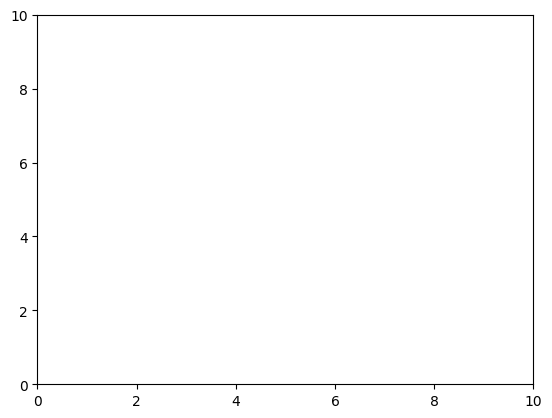

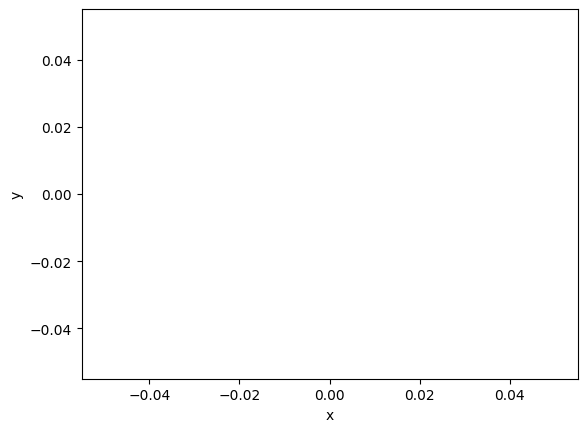

In [33]:
%matplotlib inline
draw_polygon(mouse_input_polygon)
save_polygon_to_file(mouse_input_polygon, "test__.txt")

In [34]:
from math import sin, cos, pi
import random

def generate_circle_points(n, R1, R2):
    points = []
    angle = 0
    delta = 2*pi / n
    ys = set()
    for i in range(n):
        R = random.uniform(R1, R2)
        y = R * sin(angle)
        while y is ys:
            R = random.uniform(R1, R2)
            y = R * sin(angle)
        points.append((R * cos(angle), y))
        ys.add(y)
        angle += delta

    return points

No such comm: c18dcd7cbcfc40229894df883a8b87b2


# Triangulacja wielokątów

# Przydatne funkcje

In [35]:
EPS = 1e-12

def orient(a, b, c):   
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c 
    return (a_x - c_x) * (b_y - c_y) - (a_y - c_y) * (b_x - c_x)

def is_connective_or_separative(a, b, c):
    global EPS
    det = orient(a, b, c)
    if a[1] > b[1] and c[1] > b[1] and det < -EPS:
        return True
    elif a[1] < b[1] and c[1] < b[1] and det < -EPS:
        return True
    return False

In [36]:
def is_y_monotonic(polygon):
    for i in range(1, len(polygon)-1):
        if is_connective_or_separative(polygon[i-1], polygon[i], polygon[i+1]):
            return False
    
    if len(polygon) > 2 and is_connective_or_separative(polygon[-2], polygon[-1], polygon[0]):
        return False
    return True

***

# Podział wierzchołków na kategorie

Wierzchołki naszego wielokąta możemy podzielić na parę kategorii:
- początkowe, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których wielokąt zaczyna się monotoniczny spadek 
- końcowe, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których monotoniczność wielokąta się zmienia, czyli na przykład zaczyna się monotoniczny wzrost, jeśli wcześniej był spadek, lub na odwrót.

Wierzchołki startowe i końcowe są ważne w kontekście algorytmów przetwarzania wielokątów monotonicznych, takich jak algorytmy dziel i zwyciężaj oraz triangulacji. 
- dzielący, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które wyznaczają przekątne (linie łączące), tworzące trójkąty podczas triangulacji.
- łączący, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które są połączone liniami (przekątnymi) wewnątrz wielokąta, tworząc trójkąty.

Wierzchołki łączące i dzielące odgrywają kluczową rolę w procesie triangulacji wielokątów, pozwalając na podział figury na trójkąty w sposób bezkolizyjny. 
- prawdiłowy, pozostałe przypadki, jeden sąsiad powyżej drugi poniżej


In [37]:
EPS = 1e-12

def color_vertex(polygon):
    """
    Funkcja dzieli wierzchołki na kategorie i przypisuje wierzchołkom odpowiednie numery: 0 - początkowy, 1 - końcowy, 2 - łączący, 3 - dzielący, 4 - prawdiłowy
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica o długości n, gdzie n = len(polygon), zawierająca cyfry z przedziału 0 - 4, gdzie T[i] odpowiada kategorii i-tego wierzchołka.
    """
    global EPS
    
    if len(polygon) == 1: return [0]
    if len(polygon) == 2: return [0, 1] if polygon[0][1] > polygon[1][1] else [1, 0]

    colors = [4]*len(polygon)
    for i in range(len(polygon)):
        a = polygon[i-1] if i > 0 else polygon[-1]
        b = polygon[i]
        c = polygon[i+1] if i < len(polygon)-1 else polygon[0]
        
        det = orient(a, b, c)
        
        if a[1] < b[1] and c[1] < b[1] and det > EPS:
            colors[i] = 0
        elif a[1] > b[1] and c[1] > b[1] and det > EPS:
            colors[i] = 1
        elif a[1] > b[1] and c[1] > b[1] and det < -EPS:
            colors[i] = 2
        elif a[1] < b[1] and c[1] < b[1] and det < -EPS:
            colors[i] = 3
    
    return colors

***

In [38]:
def get_point_side(polygon): # right = 0, left = 1, start = 11, end = 10
    sides = [0]*len(polygon)
    colors = color_vertex(polygon)

    start = colors.index(0)
    end = colors.index(1)

    if end >= start:
        for i in range(start + 1, end):
            sides[i] = 1
    else:
        for i in range(start + 1, len(polygon)):
            sides[i] = 1
        for i in range(0, end):
            sides[i] = 1
    
    
    sides[start] = 11
    sides[end] = 10
    
    return sides, end

def inside_polygon(a, b, c, chain_side):
    if chain_side == 1:
        return orient(a, b, c) > 0
    else:
        return orient(a, b, c) < 0

def is_neighbour(a_idx, b_idx, n):
    if abs(a_idx - b_idx) == 1:
        return True
    elif abs(a_idx - b_idx) == n - 1:
        return True
    return False

def sort_points_by_y(polygon, points):
    return sorted(points, key = lambda x: -polygon[x][1])

In [39]:
from queue import PriorityQueue
from sortedcontainers import SortedSet
import math
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def split_into_monotone_fragments(given_polygon):
    if is_y_monotonic(given_polygon): 
        l = []
        l.append([i for i in range(len(given_polygon))])
        return l, set()

    sorted_points = sorted(given_polygon, key = lambda x: x[1], reverse=True)
    T = SortedSet(key = lambda x: min(given_polygon[x[0]][0], given_polygon[x[1]][0]))

    helper = dict()

    for i in range(len(given_polygon)):
        i2 = (i+1)%len(given_polygon)
        if given_polygon[i][1] > given_polygon[i2][1]:
            helper[(i, i2)] = i
            helper[(i2, i)] = i
        else:
            helper[(i, i2)] = i2
            helper[(i2, i)] = i2

    col = color_vertex(given_polygon)

    edges = set()

    for i in range(len(sorted_points)):
        point, point_ind = sorted_points[i], given_polygon.index(sorted_points[i])

        if col[point_ind] == 0: # start vertex
            second_point_ind = (point_ind+1)%len(given_polygon)
            T.add((point_ind, second_point_ind))
            helper[(point_ind, second_point_ind)] = point_ind
            helper[(second_point_ind, point_ind)] = point_ind
        elif col[point_ind] == 1: # end vertex
            second_point_ind = (point_ind-1)%len(given_polygon)
            if col[helper[(second_point_ind, point_ind)]] == 2:
                edges.add((given_polygon[point_ind], given_polygon[helper[(second_point_ind, point_ind)]]))
            if (second_point_ind, point_ind) in T:
                T.pop(T.index((second_point_ind, point_ind)))
        elif col[point_ind] == 3: # split vertex
            T.add((point_ind, point_ind))
            index = T.index((point_ind, point_ind))
            T.pop(index)
            edges.add((point_ind, helper[T[index-1]]))
            helper[T[index-1]] = point_ind
            helper[(T[index-1][1], T[index-1][0])] = point_ind
            T.add((point_ind, helper[T[index-1]]))
            helper[(point_ind, helper[T[index-1]])] = point_ind
            helper[(helper[T[index-1]], point_ind)] = point_ind
        elif col[point_ind] == 2: # merge vertex
            second_point_ind = (point_ind-1)%len(given_polygon)
            if col[helper[(second_point_ind, point_ind)]] == 2:
                edges.add((point_ind, helper[(second_point_ind, point_ind)]))
                T.pop(T.index((second_point_ind, point_ind)))
            
            T.add((point_ind, point_ind))
            index = T.index((point_ind, point_ind))
            T.pop(index)
            if col[helper[T[index-1]]] == 2:
                edges.add((point_ind, helper[T[index-1]]))
            helper[T[index-1]] = point_ind
            helper[(T[index-1][1], T[index-1][0])] = point_ind
            
        else: # regular vertex
            if given_polygon[point_ind][1] > given_polygon[point_ind-1][1]: # interior on left
                T.add((point_ind, point_ind))
                index = T.index((point_ind, point_ind))
                T.pop(index)
                if col[helper[T[index-1]]] == 2:
                    edges.add((point_ind, helper[T[index-1]]))
                helper[T[index-1]] = point_ind
                helper[(T[index-1][1], T[index-1][0])] = point_ind
            else: # interior on right
                second_point_ind = (point_ind-1)%len(given_polygon)
                if col[helper[(second_point_ind, point_ind)]] == 2:
                    edges.add((point_ind, helper[(second_point_ind, point_ind)]))
                if (second_point_ind, point_ind) in T:
                    T.pop(T.index((second_point_ind, point_ind)))
                next_ind = (point_ind+1)%len(given_polygon)
                T.add((point_ind, next_ind))
                helper[(point_ind, next_ind)] = point_ind
                helper[(next_ind, point_ind)] = point_ind

    # split into monotone polygons
    tp = dict()
    for e in edges:
        tp.setdefault(e[0], [])
        tp.setdefault(e[1], [])
        tp[e[0]].append(e[1])
        tp[e[1]].append(e[0])

    visited = [False]*len(given_polygon)

    polygons = []

    for i in range(len(given_polygon)):
        if not visited[i] and i not in tp.keys():
            polygon = []
            polygon.append(i)
            visited[i] = True
            d = (i+1)%len(given_polygon)
            if i in tp.keys():
                j = tp[i]
            else:
                j = (i+1)%len(given_polygon)
            while j != i:
                visited[j] = True
                polygon.append(j)
                to = (j+1)%len(given_polygon)
                if j in tp.keys():
                    for dest in tp[j]:
                        if getAngle(given_polygon[polygon[-2]], given_polygon[polygon[-1]], given_polygon[to]) < getAngle(given_polygon[polygon[-2]], given_polygon[polygon[-1]], given_polygon[dest]):
                            to = dest
                
                j = to

            polygons.append(polygon)
    
    return polygons, edges

In [40]:
def triangulation_general(given_polygon):
    #spliting polygon into monotone sections
    polygons, edges = split_into_monotone_fragments(given_polygon)

    #triangulating those monotone parts
    triangles = []
    diags = list(edges)

    indices_org = dict()
    for i, p in enumerate(given_polygon):
        indices_org[p] = i

    for polygon_indices in polygons:
        last_diag_local_coords = None
        polygon = list(map(lambda x: given_polygon[x], polygon_indices))
        chain_side, end_point = get_point_side(polygon)
        points = sort_points_by_y(polygon, [i for i in range(len(polygon))])
        n = len(polygon)

        Q = []
            
        Q.append(points[0])
        Q.append(points[1])
        for i in range(2, n):
            if chain_side[points[i]] != chain_side[Q[-1]]:
                prev_last = Q[-1]
                while len(Q) > 0:
                    p = Q.pop()
                    if not is_neighbour(points[i], p, n):
                        diags.append((indices_org[polygon[points[i]]], indices_org[polygon[p]]))
                        last_diag_local_coords = (points[i], p)
                        if len(Q) > 0:
                            triangles.append((indices_org[polygon[points[i]]], indices_org[polygon[p]], indices_org[polygon[Q[-1]]]))
                if i < n -1:
                    Q.append(prev_last)
                    Q.append(points[i])
            else:
                p = Q.pop()
                while len(Q) > 0 and inside_polygon(polygon[Q[-1]], polygon[p], polygon[points[i]], chain_side[p]):
                    if not is_neighbour(Q[-1], points[i], n):
                        diags.append((indices_org[polygon[points[i]]], indices_org[polygon[Q[-1]]]))
                        last_diag_local_coords = (points[i], Q[-1])
                        triangles.append((indices_org[polygon[Q[-1]]], indices_org[polygon[p]], indices_org[polygon[points[i]]]))
                    p = Q.pop()

                if i < n - 1:
                    Q.append(p)
                    Q.append(points[i])
        
        if last_diag_local_coords:
            triangles.append((indices_org[polygon[last_diag_local_coords[0]]], indices_org[polygon[last_diag_local_coords[1]]], indices_org[polygon[end_point]]))
        else:
            triangles.append((indices_org[polygon[0]], indices_org[polygon[1]], indices_org[polygon[2]]))

    return given_polygon, diags, triangles

In [41]:
def triangulation_general_vis(given_polygon):
    # drawing classified vertices
    draw_polygon(given_polygon)
    draw_polygon_colors(given_polygon, color_vertex(given_polygon))

    # spliting polygon into monotone sections
    polygons, edges = split_into_monotone_fragments(given_polygon)

    draw_polygon_with_edges(given_polygon, edges)
    #############################################################
    # triangulating those monotone parts
    triangles = []
    diags = list(edges)

    indices_org = dict()
    for i, p in enumerate(given_polygon):
        indices_org[p] = i

    vis = Visualizer()
    for polygon_indices in polygons:
        vis.add_polygon(given_polygon, fill=False, zorder=0)
    vis.add_line_segment(list(map(lambda x: (given_polygon[x[0]], given_polygon[x[1]]), edges)), color="blue", zorder=0)

    for polygon_indices in polygons:
        last_diag_local_coords = None
        polygon = list(map(lambda x: given_polygon[x], polygon_indices))
        chain_side, end_point = get_point_side(polygon)
        points = sort_points_by_y(polygon, [i for i in range(len(polygon))])
        n = len(polygon)

        Q = []
        Q_points = []
        current_point = None
        c = "yellow"
        ls = "--"
        zo = 99
        Q_points.append(vis.add_point(polygon[points[0]], color='green'))
        Q_points.append(vis.add_point(polygon[points[1]], color='green'))
            
        Q.append(points[0])
        Q.append(points[1])
        for i in range(2, n):
            if current_point != None: vis.remove_figure(current_point)
            current_point = vis.add_point(polygon[points[i]], color='blue', zorder=99)
            if chain_side[points[i]] != chain_side[Q[-1]]:
                prev_last = Q[-1]
                while len(Q) > 0:
                    p = Q.pop()
                    vis.remove_figure(Q_points.pop())
                    if not is_neighbour(points[i], p, n):
                        diags.append((indices_org[polygon[points[i]]], indices_org[polygon[p]]))
                        last_diag_local_coords = (points[i], p)
                        if len(Q) > 0:
                            triangles.append((indices_org[polygon[points[i]]], indices_org[polygon[p]], indices_org[polygon[Q[-1]]]))
                            vis.add_line_segment([(polygon[points[i]], polygon[p]), (polygon[p], polygon[Q[-1]]),(polygon[Q[-1]], polygon[points[i]])], color=c, linestyle=ls, zorder=zo)
                            if c == "yellow":
                                c = "red"
                                ls = "dotted"
                                zo = 99
                            else:
                                c = "yellow"
                                ls = "--"
                                zo = 98
                if i < n -1:
                    Q.append(prev_last)
                    Q.append(points[i])
                    Q_points.append(vis.add_point(polygon[prev_last], color='green'))
                    Q_points.append(vis.add_point(polygon[points[i]], color='green'))
            else:
                p = Q.pop()
                vis.remove_figure(Q_points.pop())
                while len(Q) > 0 and inside_polygon(polygon[Q[-1]], polygon[p], polygon[points[i]], chain_side[p]):
                    if not is_neighbour(Q[-1], points[i], n):
                        diags.append((indices_org[polygon[points[i]]], indices_org[polygon[Q[-1]]]))
                        last_diag_local_coords = (points[i], Q[-1])
                        triangles.append((indices_org[polygon[Q[-1]]], indices_org[polygon[p]], indices_org[polygon[points[i]]]))
                        vis.add_line_segment([(polygon[points[i]], polygon[p]), (polygon[p], polygon[Q[-1]]),(polygon[Q[-1]], polygon[points[i]])], color=c, linestyle=ls, zorder=zo)
                        if c == "yellow":
                            c = "red"
                            ls = "dotted"
                            zo = 99
                        else:
                            c = "yellow"
                            ls = "--"
                            zo = 98
                    p = Q.pop()
                    vis.remove_figure(Q_points.pop())

                if i < n - 1:
                    Q.append(p)
                    Q.append(points[i])
                    Q_points.append(vis.add_point(polygon[p], color='green'))
                    Q_points.append(vis.add_point(polygon[points[i]], color='green'))

        if last_diag_local_coords:
            triangles.append((indices_org[polygon[last_diag_local_coords[0]]], indices_org[polygon[last_diag_local_coords[1]]], indices_org[polygon[end_point]]))
            vis.add_line_segment([(polygon[last_diag_local_coords[0]], polygon[last_diag_local_coords[1]]), (polygon[last_diag_local_coords[1]], polygon[end_point]), (polygon[end_point], polygon[last_diag_local_coords[0]])], color=c, linestyle=ls, zorder=zo)
        else:
            triangles.append((indices_org[polygon[0]], indices_org[polygon[1]], indices_org[polygon[2]]))
            vis.add_line_segment([(polygon[0], polygon[1]), (polygon[1], polygon[2]), (polygon[2], polygon[0])], color=c, linestyle=ls, zorder=zo)
        
        vis.remove_figure(current_point)
        vis.save('triangulation_result')
        vis.save_gif('triangulation_process')

    draw_polygon_tri(given_polygon, diags, edges)

    return given_polygon, diags, triangles

In [42]:
import time

acc1 = acc2 = acc3 = acc4 = 0
for _ in range(5):
    polygon_to_triangulate = read_polygon_from_file("test_perf3.txt")
    #draw_polygon(polygon_to_triangulate)
    start = time.perf_counter()
    polygon, diags, triangles = triangulation_general(polygon_to_triangulate)
    acc1 += time.perf_counter() - start

    polygon_to_triangulate = read_polygon_from_file("test_perf4.txt")
    #draw_polygon(polygon_to_triangulate)
    start = time.perf_counter()
    polygon, diags, triangles = triangulation_general(polygon_to_triangulate)
    acc2 += time.perf_counter() - start


    polygon_to_triangulate = read_polygon_from_file("test_perf2.txt")
    #draw_polygon(polygon_to_triangulate)
    start = time.perf_counter()
    polygon, diags, triangles = triangulation_general(polygon_to_triangulate)
    acc3 += time.perf_counter() - start

    polygon_to_triangulate = read_polygon_from_file("test_perf1.txt")
    #draw_polygon(polygon_to_triangulate)
    start = time.perf_counter()
    polygon, diags, triangles = triangulation_general(polygon_to_triangulate)
    acc4 += time.perf_counter() - start

print("1", acc1/5, "s")
print("2", acc2/5, "s")
print("3", acc3/5, "s")
print("4", acc4/5, "s")



#save_triangulation_to_file(polygon, triangles, "triangulation_result.txt")

1 0.0006590767996385693 s
2 0.0010306827985914423 s
3 0.0013658525989740157 s
4 0.0018831455992767588 s


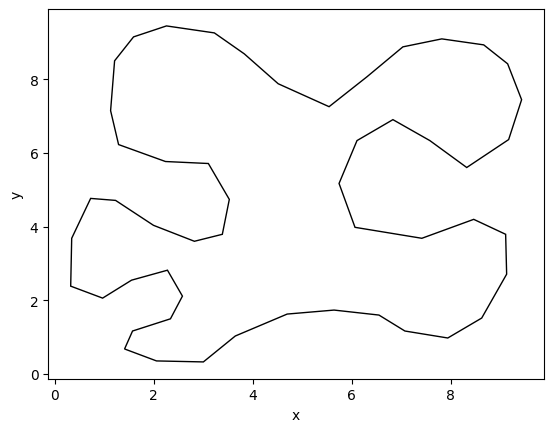

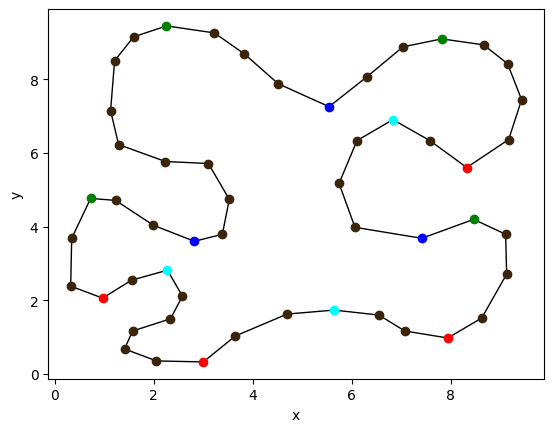

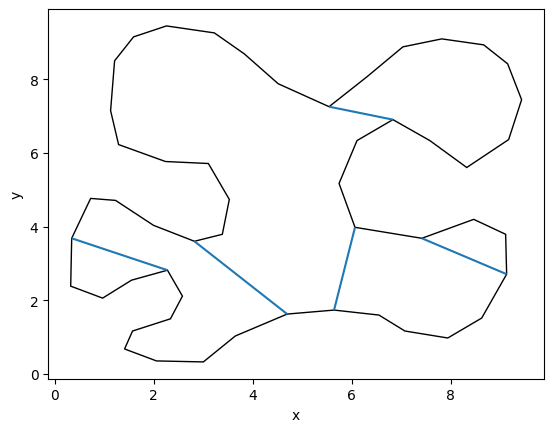

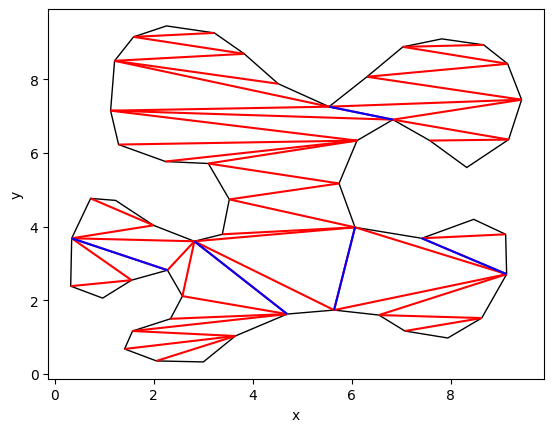

In [43]:
polygon_to_triangulate = read_polygon_from_file("test_polygon2.txt")
polygon, diags, triangles = triangulation_general_vis(polygon_to_triangulate)

In [44]:
# for i in range(1, 9):
#     polygon_to_triangulate = read_polygon_from_file(f"test_polygon{i}.txt")
#     draw_polygon(polygon_to_triangulate)
#     polygon, diags, triangles,e = triangulation_general(polygon_to_triangulate)
#     draw_polygon_tri(polygon, diags,e)

# tests = ["test_perf3.txt", "test_perf4.txt", "test_perf2.txt", "test_perf1.txt"]
# for t in tests:
#     polygon_to_triangulate = read_polygon_from_file(t)
#     draw_polygon(polygon_to_triangulate)
#     polygon, diags, triangles,e = triangulation_general(polygon_to_triangulate)
#     draw_polygon_tri(polygon, diags,e)